This project is about the "Chain of Density" approach for summarization of LLM. I used GPT-3.5 Turbo and GPT-4 models to generate summaries of Wikipedia articles. I used a template prompt to generate summaries.

The template prompt is as follows:
"You will generate increasingly concise, entity-dense summaries of the \"Article\"}. Repeat the following 2 steps _ times. Step 1. Identify 1-3 informative Entities ("," delimited) from the Article which are missing from the previously generated summary. Step 2. Write a new, denser summary of identical length which covers every entity and detail from the previous summary plus the Missing Entities. A Missing Entity is: - Relevant: to the main story. - Specific: descriptive yet concise (5 words or fewer). - Novel: not in the previous summary. - Faithful: present in the Article. - Anywhere: located anywhere in the Article. Guidelines: - The first summary should be long (4-5 sentences, ~_ words) yet highly non-specific, containing little information beyond the entities marked as missing. Use overly verbose language and fillers (e.g., "this article discusses") to reach ~_ words. - Make every word count: re-write the previous summary to improve flow and make space for additional entities. - Make space with fusion, compression, and removal of uninformative phrases like "the article discusses". - The summaries should become highly dense and concise yet self-contained, e.g., easily understood without the Article. - Missing entities can appear anywhere in the new summary. - Never drop entities from the previous summary. If space cannot be made, add fewer new entities. Remember, use the exact same number of words for each summary. Answer in JSON. The JSON should be a list ( length _) of dictionaries whose keys are " Missing_Entities" and " Denser_Summary"

Overall I generated 150 summaries with a template prompt (50 summaries for each article - 10 times 5 summaries for each article). I also generated 30 summaries with a vanilla prompt (10 summaries for each article). I used the following articles:
1. https://en.wikipedia.org/wiki/J._A._Baczewski
2. https://en.wikipedia.org/wiki/Institute_of_Electrical_and_Electronics_Engineers
3. https://en.wikipedia.org/wiki/2023_Nepal_earthquake

For evaluation and comparing I used such metrics which I inforamlly divided into metrics and not_metrics:
Metrics: density, fusion, content distribution
Not_metrics: number of tokens, number of entities, abstractiveness.

I also used ROUGE to calculate the fusion of the summaries.

In [1]:
import json
import os
import re
import urllib.request

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
from bs4 import BeautifulSoup
from nltk import word_tokenize
from rouge import Rouge
from openai import OpenAI

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sailor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
MODEL = ["gpt-3.5-turbo", "gpt-4"]
AMOUNT_OF_SUMMARIES = 5
SUMMARY_LENGTH = 60
WIKI_URL = ['https://en.wikipedia.org/wiki/J._A._Baczewski',
            'https://en.wikipedia.org/wiki/Institute_of_Electrical_and_Electronics_Engineers',
            'https://en.wikipedia.org/wiki/2023_Nepal_earthquake']
PROMPT_TEMPLATE = """You will generate increasingly concise, entity-dense summaries of the \"Article\"}.
Repeat the following 2 steps _ times.
Step 1. Identify 1-3 informative Entities ("," delimited) from the Article which are missing from the previously generated summary.
Step 2. Write a new, denser summary of identical length which covers every entity and detail from the previous summary plus the Missing Entities.
A Missing Entity is:
- Relevant: to the main story.
- Specific: descriptive yet concise (5 words or fewer).
- Novel: not in the previous summary.
- Faithful: present in the Article.
- Anywhere: located anywhere in the Article.
Guidelines:
- The first summary should be long (4-5 sentences, ~_ words) yet highly non-specific, containing little information beyond the entities marked as missing. Use overly verbose language and fillers (e.g., "this article discusses") to reach ~_ words.
- Make every word count: re-write the previous summary to improve flow and make space for additional entities.
- Make space with fusion, compression, and removal of uninformative phrases like "the article discusses".
- The summaries should become highly dense and concise yet self-contained, e.g., easily understood without the Article.
- Missing entities can appear anywhere in the new summary.
- Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
Remember, use the exact same number of words for each summary.
Answer in JSON. The JSON should be a list ( length _) of dictionaries
whose keys are " Missing_Entities" and " Denser_Summary"""
VANILLA_PROMPT_TEMPLATE = """You will generate increasingly concise, entity-dense summary of the \"Article\"}. It should contain 4-5 sentences, ~_ words. If you are unable to make space for additional entities, add fewer new entities write some fillers such as (this article discusses)."""

In [86]:
def process_text(text):
    """
    process_text - Processes the given text by removing unnecessary characters and stopwords.
    :param text: text to process
    :return: processed text
    """
    result = text.replace('\n', '')
    result = re.sub(r'\[\d+\]', '', result)
    result = result.replace('\\', '').replace('"', '')
    result = re.sub(r'\([^)]*\)', '', result)
    pattern = re.compile(r'([A-Z][a-z]*)?\.?([A-Z][\w]*)\.')

    result = re.sub(pattern, lambda m: m.group(0).replace(".", ""), result)

    if result.strip()[-1] == '.':
        result = result.strip()[:-1]

    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(result)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)

    return filtered_text

https://en.wikipedia.org/wiki/J._A._Baczewski
https://en.wikipedia.org/wiki/Institute_of_Electrical_and_Electronics_Engineers
https://en.wikipedia.org/wiki/2023_Nepal_earthquake

In [87]:
def fetch_data(url, model="gpt-3.5-turbo"):
    """
    fetch_data - Fetches the data from the given URL and returns the content of the article.
    :param url: URL to fetch the data from
    :return: content of the article
    """
    fetched_data = urllib.request.urlopen(url)
    doc_read = fetched_data.read()
    doc_parsed = BeautifulSoup(doc_read, 'html.parser')
    paragraphs = doc_parsed.find_all('p')
    doc_content = ''

    if model == "gpt-3.5-turbo":
        for p in paragraphs[:5]:
            doc_content += p.text + ' '
    elif model == "gpt-4":
        for p in paragraphs:
            doc_content += p.text + ' '

    return doc_content

In [88]:
def generate_summary(text, model, prompt_template=PROMPT_TEMPLATE):
    """
    generate_summary - Generates a summary of the given text using the GPT-3.5 model.

    :param text: string, text to summarize
    :param model: string, name of the large language model for usage for summarization
    :param prompt_template: string, specific prompt template for summarization
    :return: response from the chatGPT model
    """
    prompt = prompt_template.replace("\"Article\"", text)
    prompt = prompt.replace("~_ words", str(SUMMARY_LENGTH))
    prompt = prompt.replace("_ times", str(AMOUNT_OF_SUMMARIES) + " times")
    prompt = prompt.replace("length _", "length " + str(AMOUNT_OF_SUMMARIES))

    client = OpenAI(
        api_key=os.environ['OPENAI_API_KEY'],
    )

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )

    return response

In [89]:
def to_json(json_like_object):
    """
    to_json - Converts the given JSON-like object to JSON.
    :param json_like_object: JSON-like object (string object with json format)
    :return: JSON object (missing entities, summaries)
    """
    data = json.loads(json_like_object.content.replace('\n', ''))
    mis_ent = [item['Missing_Entities'] for item in data]
    summ = [item['Denser_Summary'] for item in data]

    return mis_ent, summ

In [90]:
def get_num_tokens_entities_density(summ):
    """
    get_num_tokens_entities_density - Returns the number of tokens, number of unique entities and density of the given summary.
    :param summ: string, summary to analyze
    :return: number of tokens, number of unique entities and density of the given summary
    """
    nlp = spacy.load("en_core_web_sm")

    num_tokens = len(word_tokenize(summ))

    entities_summ = nlp(summ)

    unique_entities_summ = set([ent.text for ent in entities_summ.ents])

    num_unique_entities_summ = len(unique_entities_summ)

    dens = num_unique_entities_summ / len(word_tokenize(summ))

    return num_tokens, num_unique_entities_summ, dens

In [161]:
def get_summary_abstractiveness(summaries):
    """
    get_summary_abstractiveness - Returns the abstractiveness(density) of the given summaries.
    :param summaries: list, list of summaries
    :return: dict, abstractiveness(density) of the given summaries
    """
    summary_abstractiveness = {}
    summary_iter = 1

    if type(summaries) == str:
        summaries = [summaries]

    if len(summaries) == 0:
        return summary_abstractiveness
    elif len(summaries) == 1:
        fragments = summaries[0].split('.')
        squared_lengths = [len(fragment.split()) ** 2 for fragment in fragments]
        average_extractive_density = sum(squared_lengths) / len(squared_lengths)
        summary_abstractiveness[summary_iter] = average_extractive_density
    else:
        for summ in summaries:
            fragments = summ.split('.')

            squared_lengths = [len(fragment.split()) ** 2 for fragment in fragments]

            average_extractive_density = sum(squared_lengths) / len(squared_lengths)

            summary_abstractiveness[summary_iter] = average_extractive_density

            summary_iter += 1

    return summary_abstractiveness

In [92]:

def calculate_rouge_gain(source, target):
    """
    calculate_rouge_gain - Calculates the rouge gain between the given source and target.
    :param source: source sentence(from the article)
    :param target: target sentence(from the summary)
    :return: rouge gain
    """
    evaluator = Rouge()
    scores = evaluator.get_scores(source, target)
    return scores[0]['rouge-1']['f']

In [93]:
def get_fusion(summary, source_sentences, summary_iter, summary_ranks, summary_fusions):
    """
    get_fusion - Calculates the fusion of the given summary.
    :param summary: summary to calculate the fusion
    :param source_sentences: source sentences(from the article)
    :param summary_iter: iteration of the summary
    :param summary_ranks: dict, ranks of the summary
    :param summary_fusions: dict, fusions of the summary
    :return: dict, ranks of the summary, dict, fusions of the summary
    """
    fusion = 0
    summary_ranks_per_summary = []

    if summary.strip()[-1] == '.':
        summary = summary.strip()[:-1]

    for sentence in summary.split('.'):
        aligned_sentences = []
        ranks = []
        target_sentence = sentence
        for ss in source_sentences:
            rouge_gain = calculate_rouge_gain(ss, target_sentence)
            if rouge_gain > 0:
                aligned_sentences.append(ss)
                rank = source_sentences.index(ss) + 1
                ranks.append(rank)

        average_fusion = len(aligned_sentences) / len(target_sentence.split())
        fusion += average_fusion
        summary_ranks_per_summary.append(ranks)

    summary_ranks[summary_iter] = summary_ranks_per_summary
    summary_fusions[summary_iter] = (fusion / len(summary.split('.')))
    return summary_ranks, summary_fusions

In [94]:
def calculate_content_distribution(summary_ranks):
    """
    calculate_content_distribution - Calculates the content distribution of the given summary ranks.
    :param summary_ranks: dict, ranks of the summary
    :return: dict, content distribution of the given summary ranks
    """
    summary_content_distribution = {}
    summary_iter = 1

    for ranks_per_summary in summary_ranks.values():
        if isinstance(ranks_per_summary[0], list):
            all_ranks = [rank for ranks in ranks_per_summary for rank in ranks]
        else:
            all_ranks = ranks_per_summary

        if all_ranks:
            average_rank = sum(all_ranks) / len(all_ranks)
            summary_content_distribution[summary_iter] = average_rank
        else:
            summary_content_distribution[summary_iter] = 0
        summary_iter += 1

    return summary_content_distribution

In [95]:
def write_into_file(path, amount_of_summaries, summ_metrics=True, dens='', fus='', con_dis='', tokens='', entities='',
                    density=''):
    """
    write_into_file - Writes the given metrics into the given file.
    :param path: path of the file
    :param amount_of_summaries: amount of summaries
    :param dens: density
    :param fus: fusion
    :param con_dis: content distribution
    :param tokens: number of tokens
    :param entities: number of entities
    :param density: density
    :param summ_metrics: boolean, whether to write summary metrics or not
    :return: None
    """
    with open(path, "a") as file:
        if summ_metrics:
            if os.stat(path).st_size == 0:
                file.write("Summary,Density,Fusion,Content Distribution\n")
            if len(dens) == len(fus) == len(con_dis) == 1:
                file.write("{},{},{},{}\n".format(
                    1,
                    dens[1],
                    fus[1],
                    con_dis[1]
                )
                )
            else:
                for j in range(1, amount_of_summaries + 1):  # dict keys start from 1
                    file.write("{},{},{},{}\n".format(
                        j,
                        dens[j],
                        fus[j],
                        con_dis[j]
                    )
                    )
        else:
            if os.stat(path).st_size == 0:
                file.write("Summary,Entity,Token,Density\n")
            if len(tokens) == len(entities) == len(density) == 1:
                file.write("{},{},{},{}\n".format(
                    0,
                    tokens[0],
                    entities[0],
                    density[0]
                )
                )
            else:
                for j in range(0, len(tokens)):  # dict keys start from 1
                    file.write("{},{},{},{}\n".format(
                        j,
                        tokens[j],
                        entities[j],
                        density[j]
                    )
                    )

In [285]:
def plot_metrics(
        t_df,
        title,
        v_df,
        df_cols=('Summary', 'Density', 'Fusion', 'Content Distribution')
):
    """
    plot_metrics - Plots the given metrics.
    :param t_df: template metrics dataframe
    :param title: title of the plot
    :param v_df: vanilla metrics dataframe
    :param df_cols: dataframe columns
    :return: None
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(title)
    ax1.set_title(df_cols[1])
    ax1.set_xlabel(df_cols[0])
    ax1.set_ylabel(df_cols[1])
    # normalize density
    line1_ax1, = ax1.plot(
        t_df[df_cols[0]],
        [v_df[df_cols[1]] / 100 for _ in t_df[df_cols[0]]],
        label='Vanilla',
        linestyle='--')
    line2_ax1, = ax1.plot(
        t_df[df_cols[0]],
        t_df[df_cols[1]] / 100)

    ax2.set_title(df_cols[2])
    ax2.set_xlabel(df_cols[0])
    ax2.set_ylabel(df_cols[2])
    line1_ax2, = ax2.plot(t_df[df_cols[0]],
                          [v_df[df_cols[2]] for _ in t_df[df_cols[0]]],
                          label='Vanilla',
                          linestyle='--')
    line2_ax2, = ax2.plot(
        t_df[df_cols[0]],
        t_df[df_cols[2]])

    ax3.set_title(df_cols[3])
    ax3.set_xlabel(df_cols[0])
    ax3.set_ylabel(df_cols[3])
    line1_ax3, = ax3.plot(
        t_df[df_cols[0]],
        [v_df[df_cols[3]] for _ in t_df[df_cols[0]]],
        label='Vanilla',
        linestyle='--')
    line2_ax3, = ax3.plot(t_df[df_cols[0]], t_df[df_cols[3]])

    fig.legend([line1_ax1, line2_ax1,
                line1_ax2, line2_ax2,
                line1_ax3, line2_ax3],
               ['Vanilla', 'Template'],
               loc='upper right')

    plt.show()

In [ ]:
if __name__ == "__main__":
    amount_of_requests = 1
    model_chose = 0  # 0 - gpt-3.5-turbo, 1 - gpt-4
    LLM_model = MODEL[model_chose]

    article_content = fetch_data(WIKI_URL[2], LLM_model)
    article_iterator = 2
    preprocessed_text = process_text(article_content)

    for i in range(amount_of_requests):
        if (i + 1) / 10 == 1:
            article_iterator += 1
            article_content = fetch_data(WIKI_URL[article_iterator], LLM_model)
            preprocessed_text = process_text(article_content)

        template_chatGPT_response = generate_summary(preprocessed_text, LLM_model)
        vanilla_chatGPT_response = generate_summary(preprocessed_text, LLM_model, VANILLA_PROMPT_TEMPLATE)
        template_chat = template_chatGPT_response.choices[0].message
        vanilla_chat = vanilla_chatGPT_response.choices[0].message

        template_missing_entities, template_summaries = to_json(template_chat)
        vanilla_summary = ' '.join(vanilla_chat.content.split('\n'))

        # -----------------------------------------------------------------------------------------------------

        template_tokens_entities_density = []
        vanilla_tokens_entities_density = []

        for summary in template_summaries:
            num_tokens_in_summary, num_unique_entities_in_summary, density = get_num_tokens_entities_density(summary)
            template_tokens_entities_density.append([num_tokens_in_summary, num_unique_entities_in_summary, density])

        vanilla_summary_token, vanilla_summary_entity, vanilla_summary_density = get_num_tokens_entities_density(
            vanilla_summary)
        # -----------------------------------------------------------------------------------------------------
        template_summary_abstractiveness = get_summary_abstractiveness(template_summaries)
        vanilla_summary_abstractiveness = get_summary_abstractiveness(vanilla_summary)

        # -----------------------------------------------------------------------------------------------------
        source_sentences = preprocessed_text.split('.')
        template_summary_fusions = {}
        template_summary_ranks = {}

        vanilla_summary_fusions = {}
        vanilla_summary_ranks = {}

        template_summary_iter = 1
        vanilla_summary_iter = 1

        for template_summary in template_summaries:
            template_summary_ranks, template_summary_fusions = get_fusion(template_summary, source_sentences,
                                                                          template_summary_iter, template_summary_ranks,
                                                                          template_summary_fusions)
            template_summary_iter += 1

        for vanilla_summary in [vanilla_summary]:  # Assuming vanilla_summary is defined somewhere
            vanilla_summary_ranks, vanilla_summary_fusions = get_fusion(vanilla_summary, source_sentences,
                                                                        vanilla_summary_iter, vanilla_summary_ranks,
                                                                        vanilla_summary_fusions)
            vanilla_summary_iter += 1

        # -----------------------------------------------------------------------------------------------------
        template_summary_content_distribution = calculate_content_distribution(template_summary_ranks)
        vanilla_summary_content_distribution = calculate_content_distribution(vanilla_summary_ranks)

        # -----------------------------------------------------------------------------------------------------
        write_into_file("chatGPT_4/template_prompt/summary_metrics.txt", AMOUNT_OF_SUMMARIES,
                        dens=template_summary_abstractiveness, fus=template_summary_fusions,
                        con_dis=template_summary_content_distribution)

        write_into_file("chatGPT_4/template_prompt/tokens_entities_density.txt", AMOUNT_OF_SUMMARIES,
                        summ_metrics=False, tokens=[item[0] for item in template_tokens_entities_density],
                        entities=[item[1] for item in template_tokens_entities_density],
                        density=[item[2] for item in template_tokens_entities_density])

        write_into_file("chatGPT_4/vanilla_prompt/summary_metrics.txt", AMOUNT_OF_SUMMARIES,
                        dens=vanilla_summary_abstractiveness, fus=vanilla_summary_fusions,
                        con_dis=vanilla_summary_content_distribution)

        print("Iteration {} completed".format(i + 1))


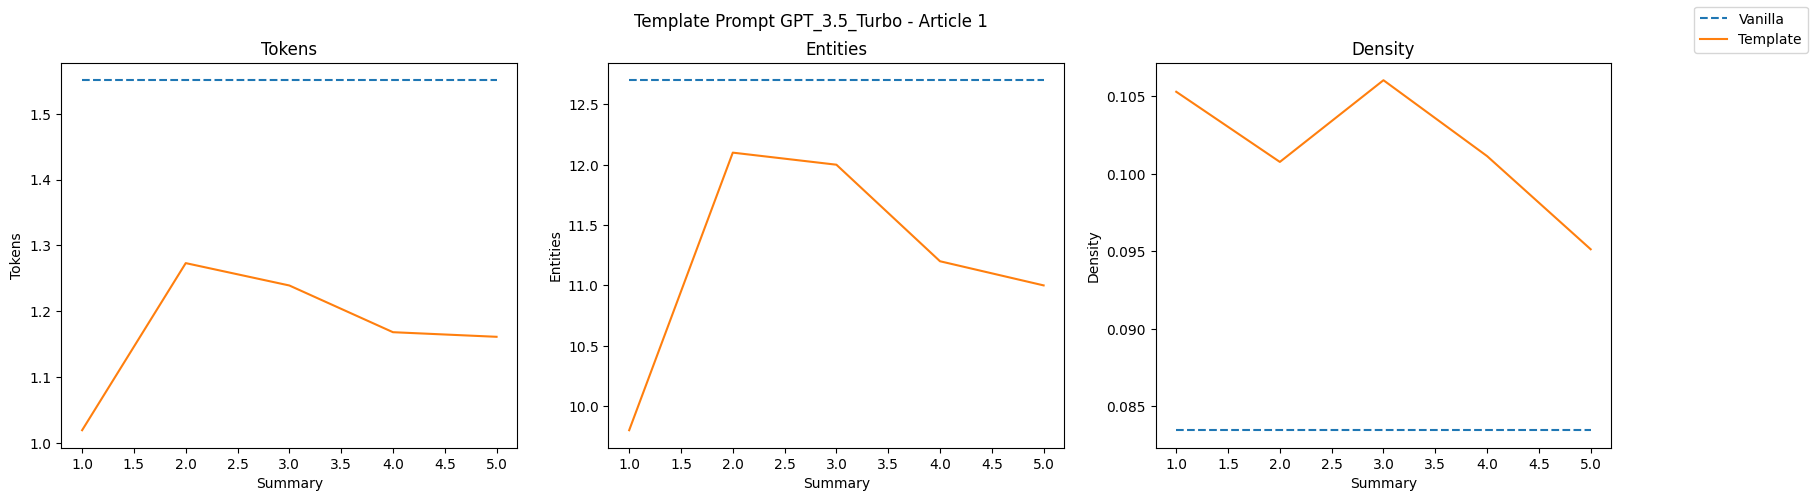

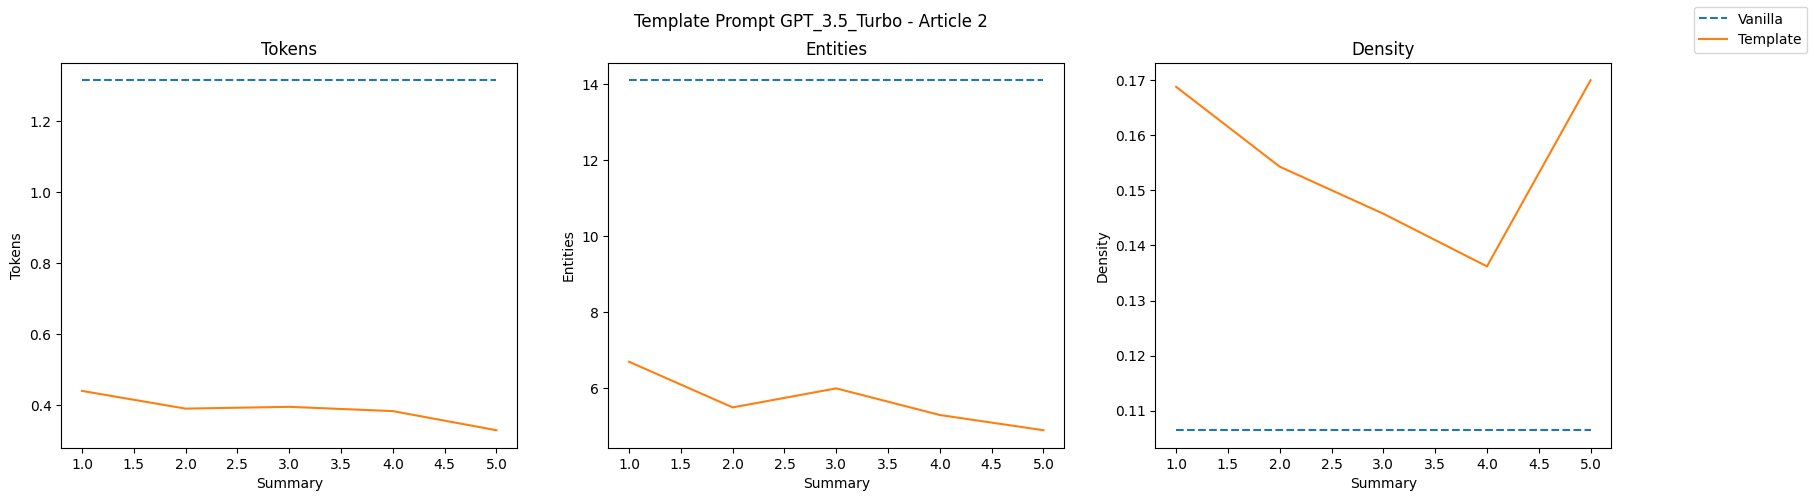

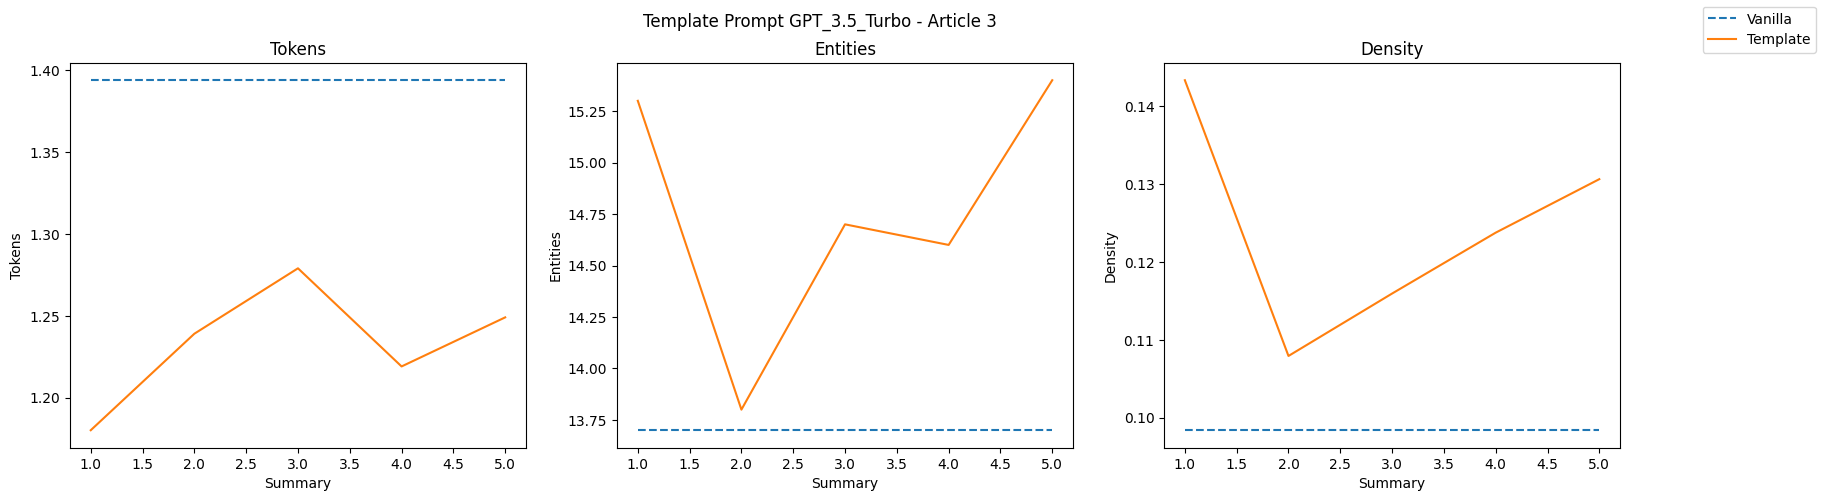

In [287]:
gpt35_vanilla_tok_ent_dens_df = pd.read_csv('chatGPT_35/vanilla_prompt/tokens_entities_density.txt', skiprows=0)
gpt35_vanilla_tok_ent_dens_df_grouped = gpt35_vanilla_tok_ent_dens_df.groupby(
    gpt35_vanilla_tok_ent_dens_df.index // 10).mean()  # because for each 10 iterations goes one article

gpt35_template_tok_ent_dens_df = pd.read_csv(
    'chatGPT_35/template_prompt/tokens_entities_density.txt',
    skiprows=0)
rows_per_part = 50  # because for each iteration we have 5 summaries and and we have 10 iterations, which leads to 50 summaries for an article
gpt35_template_tok_ent_dens_df_grouped = gpt35_template_tok_ent_dens_df.groupby(
    gpt35_template_tok_ent_dens_df.index // rows_per_part).apply(
    lambda group: group.groupby('Summary').mean().reset_index())
gpt35_template_tok_ent_dens_df_grouped.reset_index(drop=True, inplace=True)

for i in range(3):
    plot_metrics(
        gpt35_template_tok_ent_dens_df_grouped[i * 5: (i + 1) * 5],
        "Template Prompt GPT_3.5_Turbo | TOKENS/ENTITIES/DENSITY - Article {}".format(i + 1),
        gpt35_vanilla_tok_ent_dens_df_grouped.iloc[i],
        df_cols=('Summary', 'Tokens', 'Entities', 'Density'),
    )

Here we can see that the number of tokens and entities is decreasing with each iteration(except the last "unstable" one). The density is increasing with each iteration. Another words, the summary is becoming more and more dense and informative.

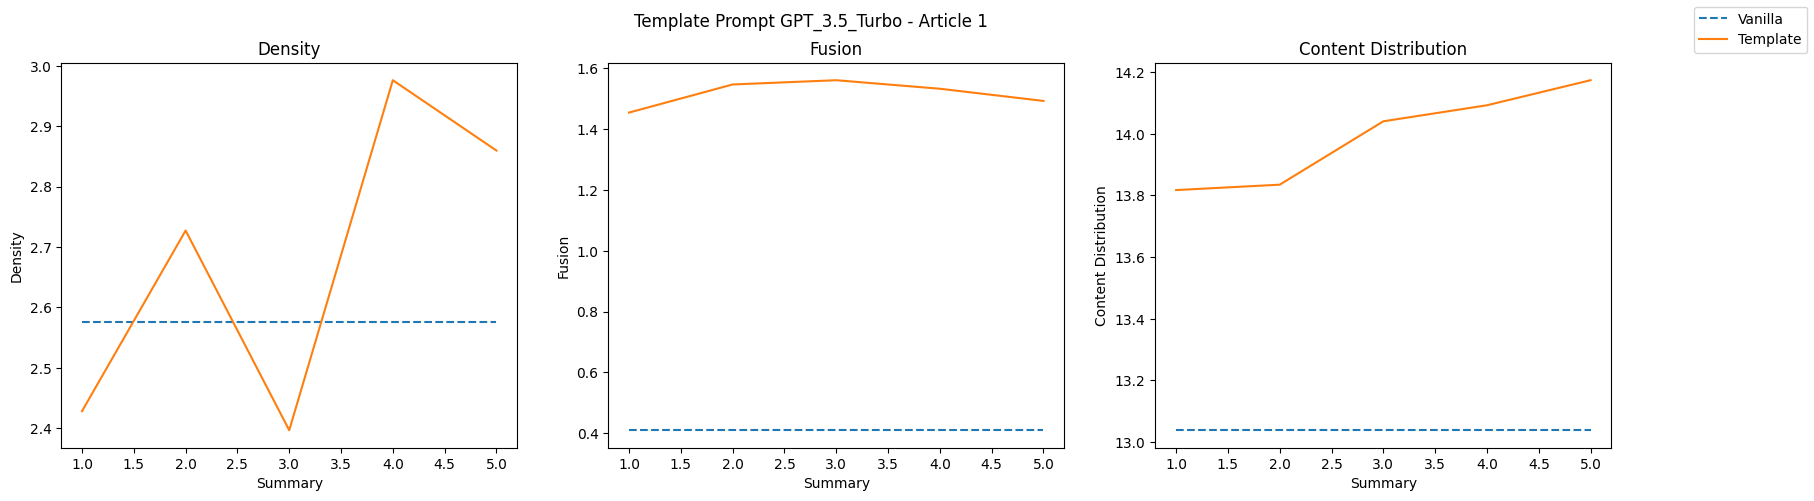

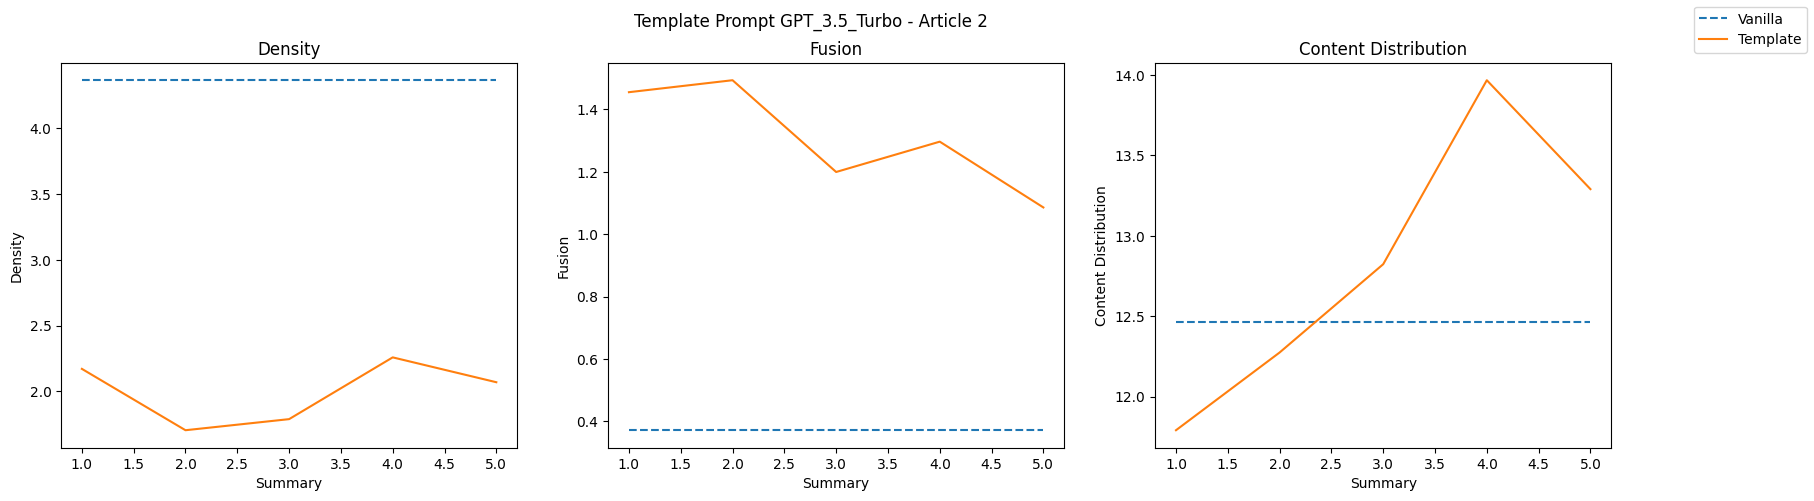

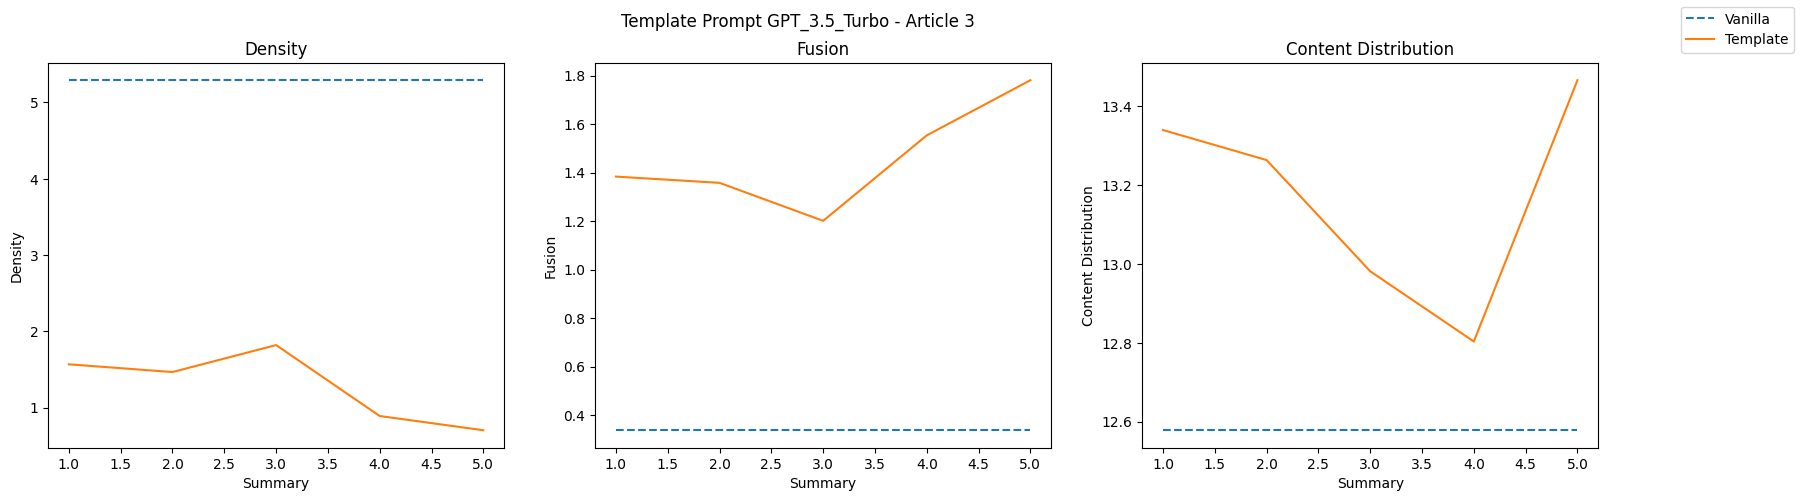

In [281]:
gpt35_vanilla_metrics_df = pd.read_csv('chatGPT_35/vanilla_prompt/summary_metrics.txt', skiprows=0)
gpt35_vanilla_metrics_df_grouped = gpt35_vanilla_metrics_df.groupby(
    gpt35_vanilla_metrics_df.index // 10).mean()  # because for each 10 iterations goes one article

gpt35_template_metrics_df = pd.read_csv('chatGPT_35/template_prompt/summary_metrics.txt', skiprows=0)
rows_per_part = 50  # because for each iteration we have 5 summaries and and we have 10 iterations, which leads to 50 summaries for an article

gpt35_template_metrics_df_grouped = gpt35_template_metrics_df.groupby(
    gpt35_template_metrics_df.index // rows_per_part).apply(lambda group: group.groupby('Summary').mean().reset_index())

gpt35_template_metrics_df_grouped.reset_index(
    drop=True,
    inplace=True)

for i in range(3):
    plot_metrics(
        gpt35_template_metrics_df_grouped[i * 5: (i + 1) * 5],
        "Template Prompt GPT_3.5_Turbo | SUMMARY METRICS - Article {}".format(i + 1),
        gpt35_vanilla_metrics_df_grouped.iloc[i],
    )

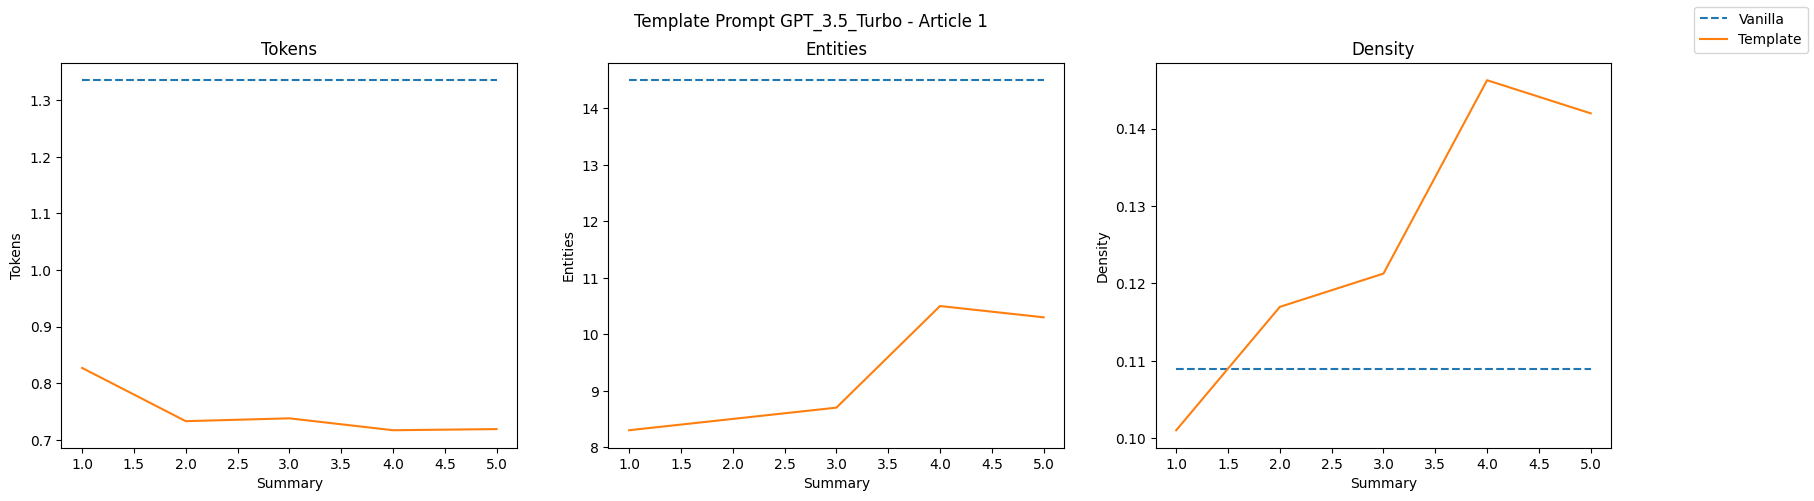

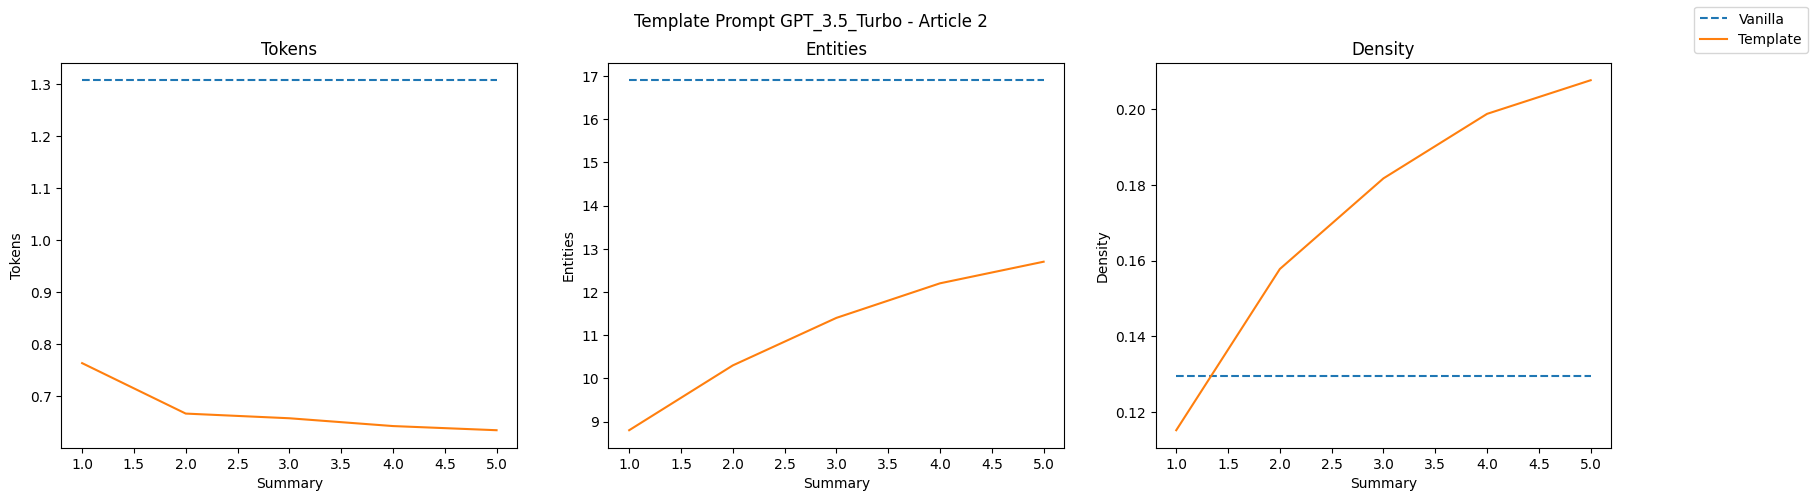

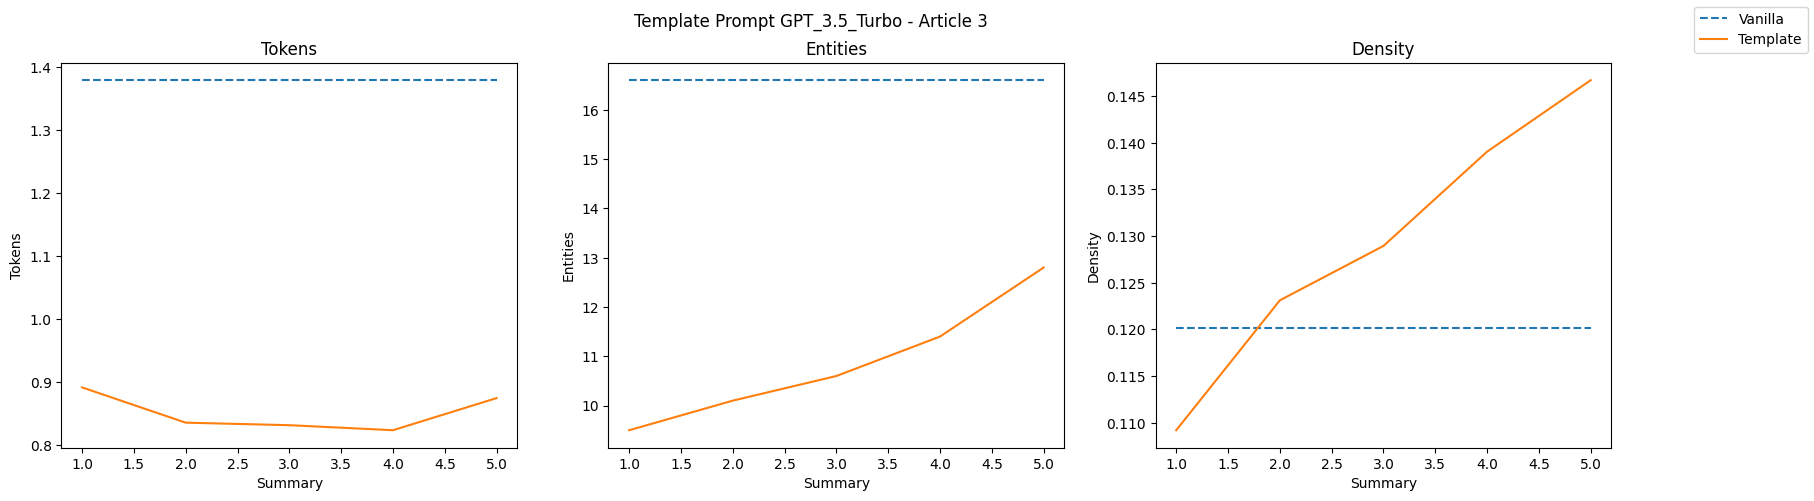

In [288]:
gpt4_vanilla_tok_ent_dens_df = pd.read_csv('chatGPT_4/vanilla_prompt/tokens_entities_density.txt', skiprows=0)
gpt4_vanilla_tok_ent_dens_df_grouped = gpt4_vanilla_tok_ent_dens_df.groupby(
    gpt4_vanilla_tok_ent_dens_df.index // 10).mean()  # because for each 10 iterations goes one article

gpt4_template_tok_ent_dens_df = pd.read_csv('chatGPT_4/template_prompt/tokens_entities_density.txt', skiprows=0)
# because for each iteration we have 5 summaries and and we have 10 iterations, which leads to 50 summaries for an article
rows_per_part = 50

gpt4_template_tok_ent_dens_df_grouped = gpt4_template_tok_ent_dens_df.groupby(
    gpt4_template_tok_ent_dens_df.index // rows_per_part).apply(
    lambda group: group.groupby('Summary').mean().reset_index())

gpt4_template_tok_ent_dens_df_grouped.reset_index(drop=True, inplace=True)

for i in range(3):
    plot_metrics(
        gpt4_template_tok_ent_dens_df_grouped[i * 5: (i + 1) * 5],
        "Template Prompt GPT_4 | TOKENS/ENTITIES/DENSITY - Article {}".format(i + 1),
        gpt4_vanilla_tok_ent_dens_df_grouped.iloc[i],
        df_cols=('Summary', 'Tokens', 'Entities', 'Density'),
    )

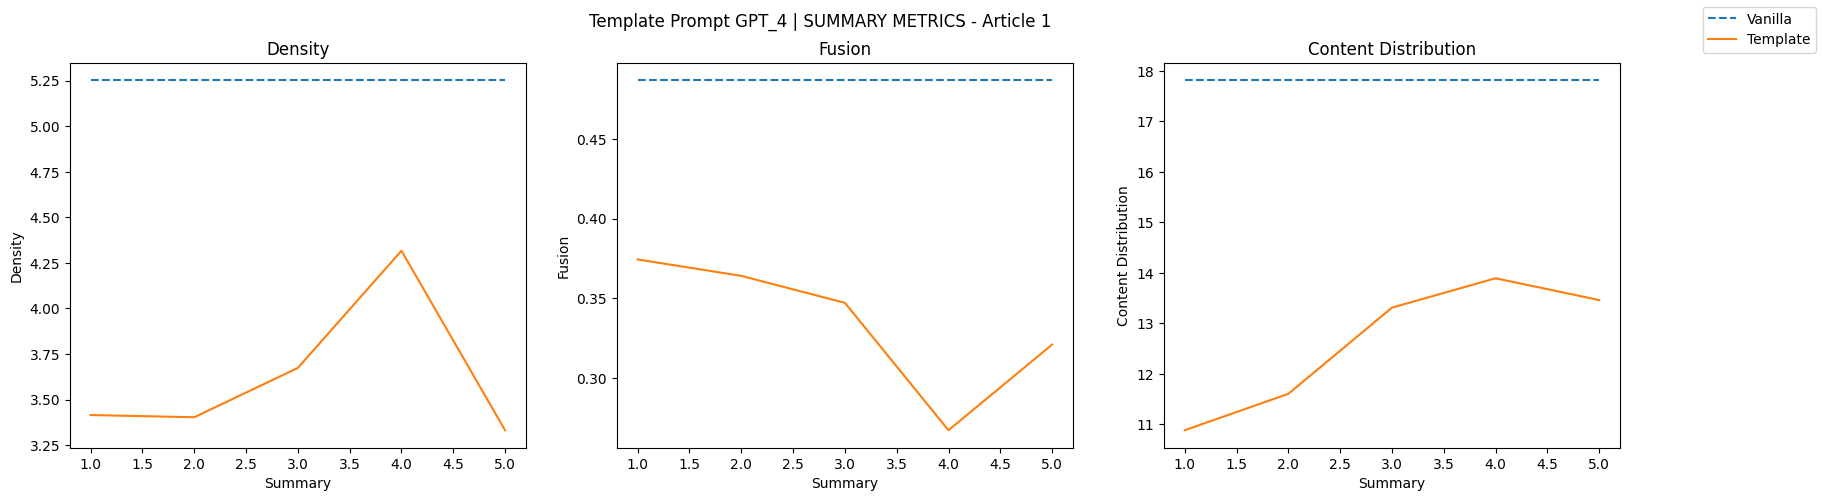

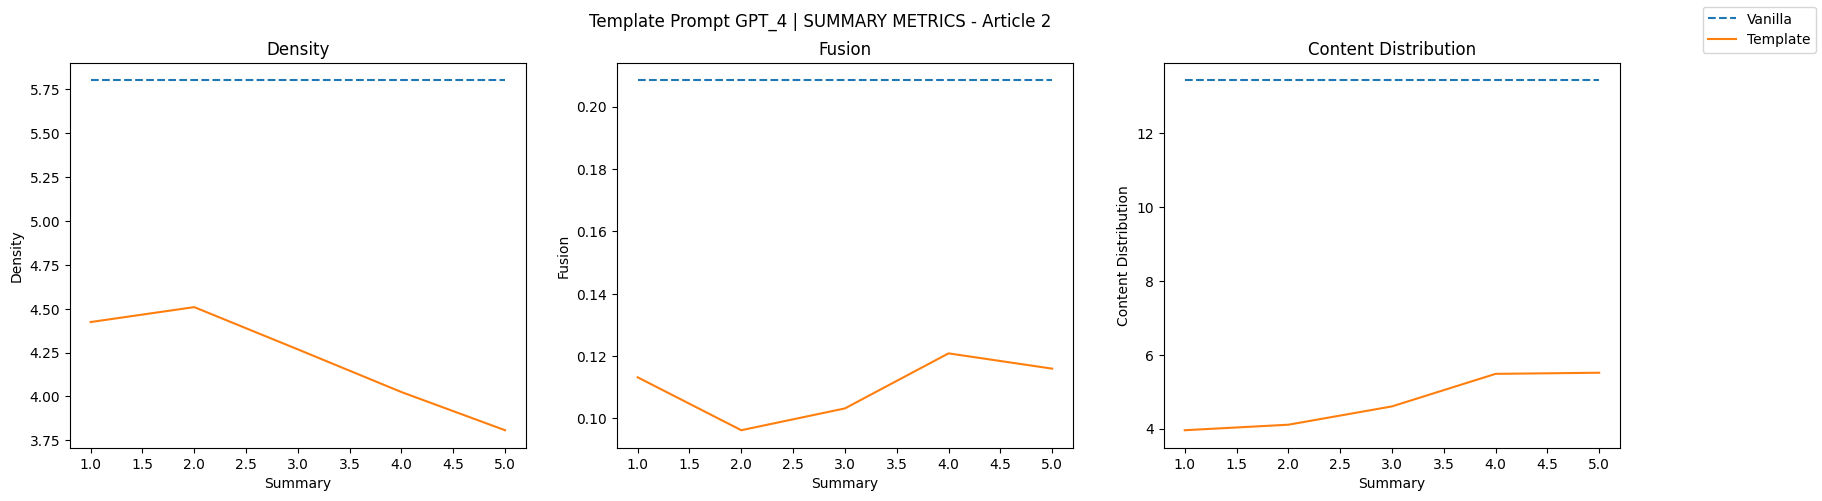

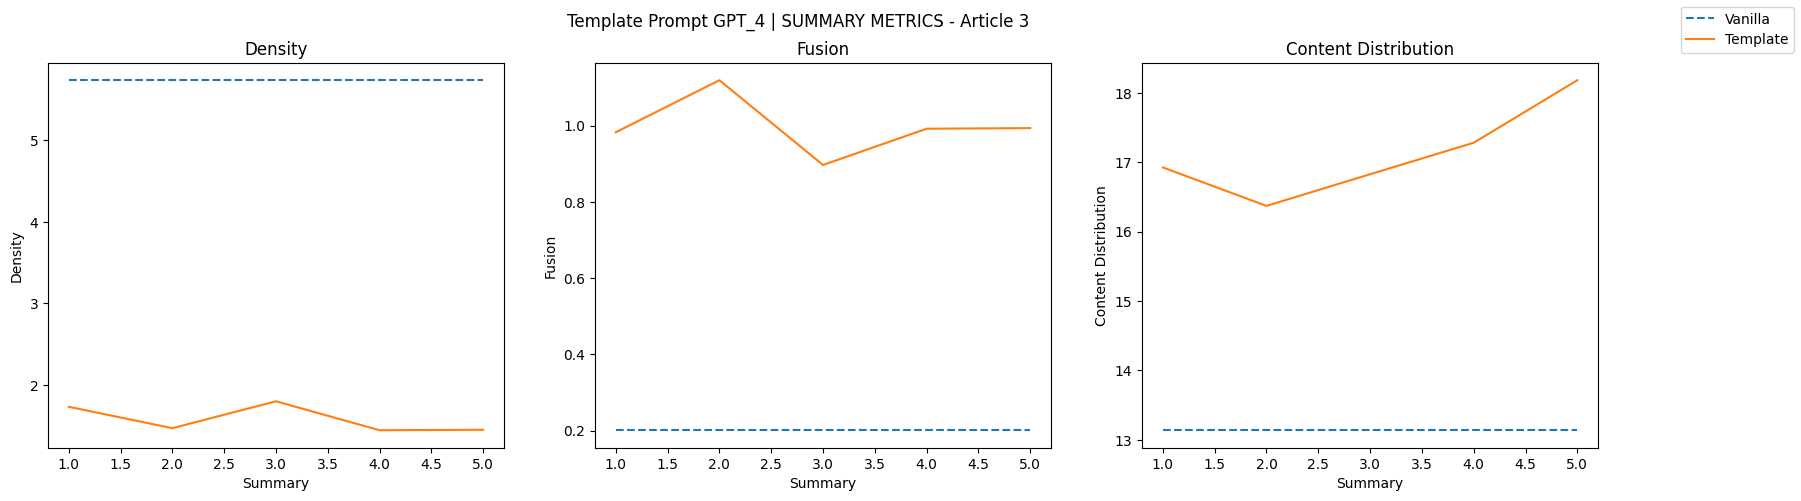

In [289]:
gpt4_vanilla_metrics_df = pd.read_csv('chatGPT_4/vanilla_prompt/summary_metrics.txt', skiprows=0)
gpt4_vanilla_metrics_df_grouped = gpt4_vanilla_metrics_df.groupby(
    gpt4_vanilla_metrics_df.index // 10).mean()  # because for each 10 iterations goes one article

gpt4_template_metrics_df = pd.read_csv('chatGPT_4/template_prompt/summary_metrics.txt', skiprows=0)
# because for each iteration we have 5 summaries and and we have 10 iterations, which leads to 50 summaries for an article
rows_per_part = 50

gpt4_template_metrics_df_grouped = gpt4_template_metrics_df.groupby(
    gpt4_template_metrics_df.index // rows_per_part).apply(lambda group: group.groupby('Summary').mean().reset_index())

gpt4_template_metrics_df_grouped.reset_index(drop=True, inplace=True)

for i in range(3):
    plot_metrics(
        gpt4_template_metrics_df_grouped[i * 5: (i + 1) * 5],
        "Template Prompt GPT_4 | SUMMARY METRICS - Article {}".format(i + 1),
        gpt4_vanilla_metrics_df_grouped.iloc[i],
    )